## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from gammapy.data import DataStore
from gammapy.maps import Map, MapAxis, WcsGeom, WcsNDMap
from gammapy.cube import MapMaker, MapFit, PSFKernel
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)
from gammapy.spectrum.models import *
from gammapy.spectrum import (
    FluxPoints,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)

from gammapy.utils.energy import EnergyBounds
from gammapy.background.reflected import ReflectedRegionsBackgroundEstimator

import astropy.units as u
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord, Angle

In [2]:
!gammapy info


System:

	python_executable      : /Users/jer/anaconda/envs/gammapy-dev/bin/python 
	python_version         : 3.7.0      
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	path                   : /Users/jer/git/gammapy/gammapy/gammapy 
	version                : 0.9.dev7902 
	githash                : 93b4238ae6a3c36e605f77eaa16b9def0692b34d 


Other packages:

	numpy                  : 1.15.4     
	scipy                  : 1.1.0      
	matplotlib             : 3.0.2      
	cython                 : 0.29       
	astropy                : 3.0.5      
	astropy_healpix        : 0.3.1      
	reproject              : 0.4        
	sherpa                 : 4.10.1     
	pytest                 : 4.0.0      
	sphinx                 : 1.7.9      
	healpy                 : 1.12.5     
	regions                : 0.3        
	iminuit                : 1.3.3      
	naima                  : 0.8.1      
	uncertainties          : 3.0.3      


Gammapy environme

## Select observations
### Catalog inspection

We can choose among four catalogs provided in the CTA 1DC
- agn
- egal
- gc
- gps

In [3]:
data_store = DataStore.from_dir("$CTADATA/index/gps")

In [4]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: /Users/jer/DATA/DC/1dc/index/gps
Rows: 19620
OBS_ID: 110000 -- 113269
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']

Observation table:
Observatory name: 'N/A'
Number of observations: 3270


In [5]:
data_store.obs_table[:5]

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,CALDB,IRF,EVENTS_FILENAME,EVENT_COUNT
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,bytes10,bytes8,bytes10,bytes8,int64,bytes21,bytes3,bytes13,bytes50,int64
110000,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662774400.0,662776192.0,2021-01-01,11:58:51,2021-01-01,12:28:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110000.fits,107301
110001,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662776320.0,662778112.0,2021-01-01,12:30:51,2021-01-01,13:00:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110001.fits,107374
110002,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662778240.0,662780032.0,2021-01-01,13:02:51,2021-01-01,13:32:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110002.fits,107579
110003,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662780160.0,662781952.0,2021-01-01,13:34:51,2021-01-01,14:04:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110003.fits,107224
110004,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662782080.0,662783872.0,2021-01-01,14:06:51,2021-01-01,14:36:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110004.fits,107052


### Pointings and Target

We will point to a specific target with galactic coordinates (40.2, -1.5) 

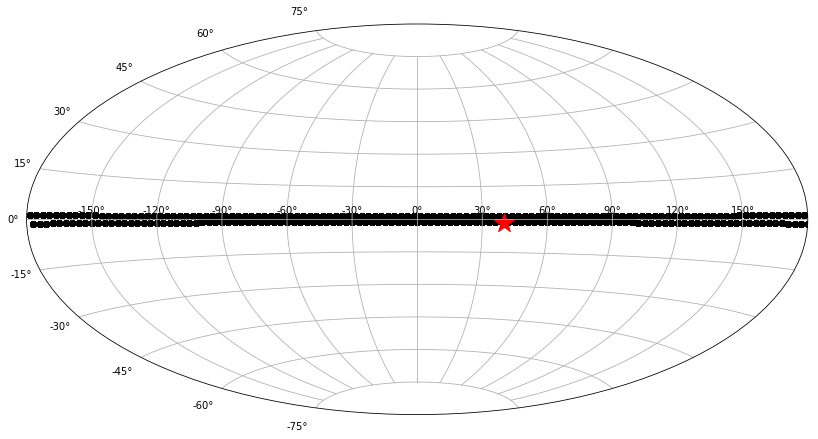

In [6]:
# Pointing positions
all_pointings = SkyCoord(data_store.obs_table['GLON_PNT'], data_store.obs_table['GLAT_PNT'], frame='galactic', unit='deg')  

# Plot pointings
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(
    all_pointings.l.wrap_at("180 deg").radian,
    all_pointings.b.wrap_at("180 deg").radian,
    color="k",
)
ax.grid(True)

#
#
# We define our selected position here !!! <---------------------------------
pos_target =  SkyCoord(40.2, -1.5, frame='galactic', unit='deg')

# Plot target
ax.scatter(
    pos_target.l.wrap_at("180 deg").radian, pos_target.b.radian, marker="*", s=400, c="red"
)

### Filter the observations

These observations have max **events offsets** of nearly 5 deg.

In [7]:
ob = data_store.obs(data_store.obs_table[1]['OBS_ID'])
ob.events.offset.max()

<Angle 4.999997 deg>

Let's filter observations taken in a radius of 2 deg of our target 

In [8]:
offset = pos_target.separation(all_pointings).deg
mask = offset < 1.5 # This is a True, False, True, False,... boolean mask 
table_selected = data_store.obs_table[mask]
table_selected

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,CALDB,IRF,EVENTS_FILENAME,EVENT_COUNT
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,bytes10,bytes8,bytes10,bytes8,int64,bytes21,bytes3,bytes13,bytes50,int64
110627,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665625600.0,665627392.0,2021-02-03,11:58:51,2021-02-03,12:28:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110627.fits,100730
110628,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665627520.0,665629312.0,2021-02-03,12:30:51,2021-02-03,13:00:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110628.fits,100439
110629,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665629440.0,665631232.0,2021-02-03,13:02:51,2021-02-03,13:32:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110629.fits,100633
110630,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665631360.0,665633152.0,2021-02-03,13:34:51,2021-02-03,14:04:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110630.fits,100983
110631,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665633280.0,665635072.0,2021-02-03,14:06:51,2021-02-03,14:36:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110631.fits,100804
110632,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665635200.0,665636992.0,2021-02-03,14:38:51,2021-02-03,15:08:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110632.fits,100940
110633,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665637120.0,665638912.0,2021-02-03,15:10:51,2021-02-03,15:40:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110633.fits,100734
110634,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665639040.0,665640832.0,2021-02-03,15:42:51,2021-02-03,16:12:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110634.fits,100690
110635,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665640960.0,665642752.0,2021-02-03,16:14:51,2021-02-03,16:44:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110635.fits,101152


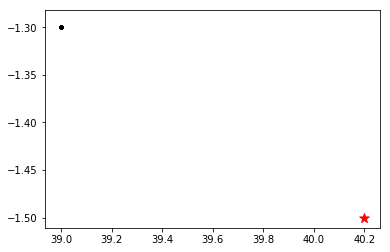

In [9]:
# Pointing positions
sel_pointings = SkyCoord(table_selected['GLON_PNT'], table_selected['GLAT_PNT'], frame='galactic', unit='deg')  

# Plot pointings
plt.scatter(
    sel_pointings.l,
    sel_pointings.b,
    color="k",
    s=10
)
ax.grid(True)

# Plot target
plt.scatter(
    pos_target.l, pos_target.b, marker="*", s=100, c="red"
)

## Make sky images

Let's havea look at the events of the first observation

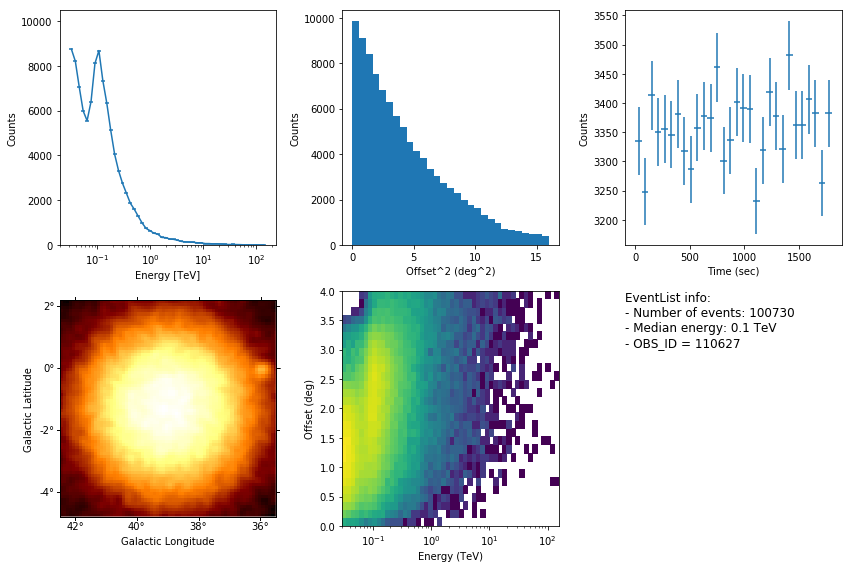

In [10]:
observations_selected = data_store.get_observations(table_selected['OBS_ID'])
events = observations_selected[0].events
events.peek()

There are about 94 000 events for a single observation, energy ranging from 1e-2 to 10 Tev.

In [11]:
energy_axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit="TeV", name="energy", interp="log"
)

In [12]:
geom = WcsGeom.create(
    skydir=pos_target,
    binsz=0.02,
    width=(5, 5),
    coordsys="GAL",
    proj="TAN",
    axes=[energy_axis],
)

In [13]:
%%time
maker = MapMaker(geom, offset_max="2.5 deg")
maps = maker.run(observations_selected)
images = maker.make_images()

CPU times: user 34.1 s, sys: 2.68 s, total: 36.7 s
Wall time: 37.1 s


In [14]:
maps.keys()

dict_keys(['counts', 'exposure', 'background'])

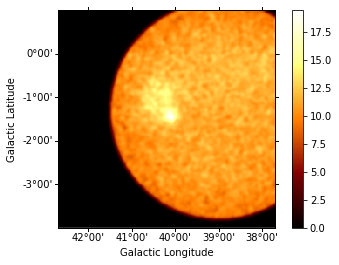

In [15]:
images["counts"].smooth(2).plot(add_cbar=True);

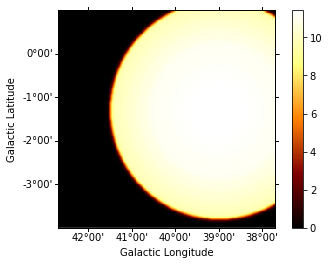

In [16]:
images["background"].smooth(2).plot(add_cbar=True);

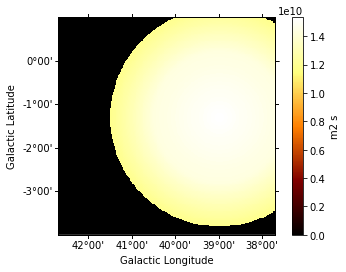

In [17]:
images["exposure"].plot(add_cbar=True);

In [18]:
excess = images["counts"].copy()
excess.data -= images["background"].data
images["excess"] = excess

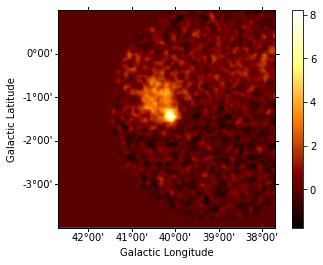

In [19]:
images["excess"].smooth(2).plot(add_cbar=True);

In [20]:
pos_target

<SkyCoord (Galactic): (l, b) in deg
    (40.2, -1.5)>

## Define on region

The next step is to define a signal extraction region around our target position, also known as on region.

In [21]:
on_region_radius = Angle("0.2 deg")
on_region = CircleSkyRegion(center=pos_target, radius=on_region_radius)

## Create exclusion mask

We will use the reflected regions method to place off regions to estimate the background level in the on region. To make sure the off regions don’t contain gamma-ray emission, we create an exclusion mask.

(<Figure size 432x288 with 1 Axes>,
 None)

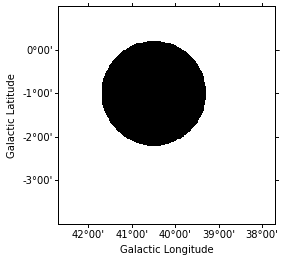

In [22]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(40.5, -1, unit="deg", frame="galactic"),
    radius=1.2 * u.deg,
)

skydir = pos_target.galactic
exclusion_mask = Map.create(
    npix=(250, 250), binsz=0.02, skydir=skydir, proj="TAN", coordsys="GAL"
)

mask = exclusion_mask.geom.region_mask([exclusion_region], inside=False)
exclusion_mask.data = mask
exclusion_mask.plot()

## Estimate background

Next we will manually perform a background estimate by placing reflected regions around the pointing positions and looking at the source statistics. This will result in a `gammapy.background.BackgroundEstimate` list that serves as input for other classes in gammapy.

In [23]:
%%time
background_estimator = ReflectedRegionsBackgroundEstimator(
    observations=observations_selected, on_region=on_region, exclusion_mask=exclusion_mask
)

background_estimator.run()

CPU times: user 15.1 s, sys: 378 ms, total: 15.5 s
Wall time: 15.6 s


/Users/jer/anaconda/envs/gammapy-dev/lib/python3.7/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


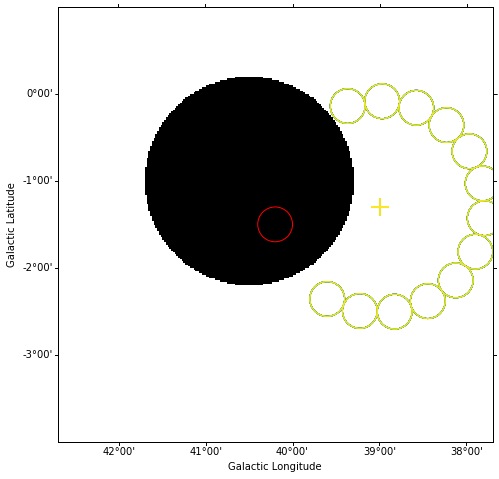

In [24]:
plt.figure(figsize=(8, 8))
background_estimator.plot();

## Extract spectrum

In [25]:
e_reco = EnergyBounds.equal_log_spacing(0.1, 10, 10, unit="TeV")
e_true = EnergyBounds.equal_log_spacing(0.1, 10, 10, unit="TeV")

In [26]:
extraction = SpectrumExtraction(
    observations=observations_selected,
    bkg_estimate=background_estimator.result,
    containment_correction=False,
    use_recommended_erange=False,
    e_reco=e_reco,
    e_true=e_true
)
extraction.run()
spec_observations = extraction.spectrum_observations

## Fit spectrum

In [27]:
%%time
model = models.PowerLaw()
fit = SpectrumFit(spec_observations, model)
fit.run()
print(fit.result[0])


Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error        unit      min max frozen
	--------- --------- --------- -------------- --- --- ------
	    index 2.164e+00 3.804e-02                nan nan  False
	amplitude 8.040e-13 3.674e-14 cm-2 s-1 TeV-1 nan nan  False
	reference 1.000e+00 0.000e+00            TeV nan nan   True

Covariance: 

	   name     index   amplitude reference
	--------- --------- --------- ---------
	    index 1.447e-03 9.150e-17 0.000e+00
	amplitude 9.150e-17 1.350e-27 0.000e+00
	reference 0.000e+00 0.000e+00 0.000e+00 

Statistic: 12.204 (wstat)
Fit Range: [ 0.1 10. ] TeV

CPU times: user 946 ms, sys: 8.21 ms, total: 954 ms
Wall time: 954 ms


## Compute Flux Points

In [28]:
# Flux points are computed on stacked observation
stacked_obs = extraction.spectrum_observations.stack()
print(stacked_obs)

*** Observation summary report ***
Observation Id: [110627-110645]
Livetime: 9.310 h
On events: 4767
Off events: 46610
Alpha: 0.077
Bkg events in On region: 3585.38
Excess: 1181.62
Excess / Background: 0.33
Gamma rate: 0.04 1 / s
Bkg rate: 0.64 1 / min
Sigma: 18.03
energy range: 0.10 TeV - 10.00 TeV


In [29]:
ebounds = EnergyBounds.equal_log_spacing(0.1, 10, 10, unit="TeV")

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_groups_fixed(ebounds=ebounds)

fpe = FluxPointEstimator(
    obs=stacked_obs, groups=seg.groups, model=fit.result[0].model
)
flux_points = fpe.run()
flux_points.table

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,loglike,norm_err,norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],dloglike_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.12589254117941673,0.1,0.15848931924611134,7.12376971259068e-11,4.179664978366902e-12,5.200661472766621e-13,1.1290414122145633e-12,0.7395154282522738,4.540197551250458e-09,0.21206917777029496,0.21353143424100965,0.21060581144993834,1.1695681497768875,3.575011141549602,12.780704662203789,0.20000000000000004 .. 5.000000000000001,6.709678296174388 .. 316.23346304678125,5.2681376097770744e-11,8.331734162191312e-11,1.510731985574036e-11,1.521148763932153e-11,1.5003073009026544e-11
0.19952623149688797,0.15848931924611134,0.251188643150958,2.629898647771033e-11,2.445516583871815e-12,4.822671994386716e-13,1.0469815095065944e-12,0.8377819137130693,9.231735020875931e-08,0.16438439894379148,0.1658685987990175,0.16290715118478877,1.1726655210098056,5.357735458456557,28.70532924280269,0.20000000000000004 .. 5.000000000000001,16.226589954458177 .. 438.6443889429502,2.2032815220010294e-11,3.083991467991402e-11,4.323143084969313e-12,4.362176036892121e-12,4.284292966131072e-12
0.31622776601683794,0.251188643150958,0.3981071705534973,9.708858057727214e-12,1.4308685966330287e-12,4.472155183957603e-13,9.708858057727213e-13,0.9452256651865154,1.021544449031353e-08,0.14436525326437172,0.14610004250643657,0.14264368061487917,1.240974812639795,7.140380310960075,50.985030985146295,0.20000000000000004 .. 5.000000000000001,30.465563368197763 .. 476.432144364182,9.177061815816665e-12,1.2048448309134393e-11,1.4016217524116253e-12,1.4184645749229052e-12,1.3849072479216368e-12
0.5011872336272724,0.3981071705534973,0.6309573444801934,3.5842417298090995e-12,8.371993689730337e-13,4.1471142994335647e-13,9.003208168357906e-13,1.0332387771506095,5.207984941080213e-07,0.13639947907533745,0.13858430537838393,0.1342448284595954,1.3145198687531279,8.650223554781224,74.82636754769192,0.20000000000000004 .. 5.000000000000001,45.940679420113156 .. 458.7535754830096,3.703377541920139e-12,4.711556968248141e-12,4.888887048260476e-13,4.967196504338113e-13,4.81165916175946e-13
0.7943282347242816,0.6309573444801934,1.0,1.3232028629237462e-12,4.898442701573977e-13,3.845697724054945e-13,8.348845645989562e-13,1.23855952654247,6.599293556064367e-09,0.14052283979410995,0.14324773437496482,0.1378344980314948,1.5305355189587797,10.906495701460399,118.95164848597415,0.20000000000000004 .. 5.000000000000001,76.92688641522545 .. 363.95865350185704,1.638865511422476e-12,2.0252089804927388e-12,1.859402239217412e-13,1.895458122322938e-13,1.823830024049314e-13
1.2589254117941675,1.0,1.584893192461114,4.884898811059964e-13,2.8660725019462196e-13,3.566188418491737e-13,7.742042871510327e-13,1.1082386696257713,9.475588740315288e-07,0.13446148651934559,0.1378893686734579,0.13110173723093976,1.3905576261271182,10.77486985339277,116.09782035755234,0.20000000000000004 .. 5.000000000000001,68.94501442365254 .. 363.89907438356386,5.413633759625606e-13,6.792733294578725e-13,6.568307556317065e-14,6.735756130907836e-14,6.404187203273134e-14
1.9952623149688804,1.584893192461114,2.511886431509581,1.803369465326662e-13,1.6769353214589599e-13,3.306994139616069e-13,7.179343153037711e-13,1.1054099320424746,2.309798219357617e-06,0.1280999324743702,0.13175574742874382,0.12452831924104794,1.3757220998767075,12.016962018540438,144.4073761550435,0.20000000000000004 .. 5.000000000000001,82.39922067439056 .. 371.5332543854829,1.9934625181142193e-13,2.4809352276927304e-13,2.310115067346865e-14,2.3760429179428845e-14,2.245705684877565e-14
3.16227766016838,2.511886431509581,3.981071705534973,6.65754

**We do not have upper limits for this Spectrum** 

All computed values for the flux are below.

In [30]:
flux_points.table['dnde', 'dnde_ul']

dnde,dnde_ul
1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64
5.2681376097770744e-11,8.331734162191312e-11
2.2032815220010294e-11,3.083991467991402e-11
9.177061815816665e-12,1.2048448309134393e-11
3.703377541920139e-12,4.711556968248141e-12
1.638865511422476e-12,2.0252089804927388e-12
5.413633759625606e-13,6.792733294578725e-13
1.9934625181142193e-13,2.4809352276927304e-13
6.580325482238674e-14,8.374395631454486e-14


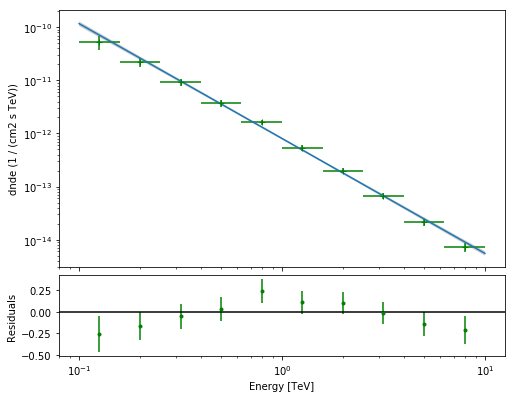

In [31]:
total_result = SpectrumResult(model=fit.result[0].model, points=flux_points)

total_result.plot(
    energy_range=[.1, 10] * u.TeV,
    fig_kwargs=dict(figsize=(8, 8)),
    point_kwargs=dict(color="green"),
);